# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188).
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems.
For the actual implementation of the graph neural network we use the open-source ```dgl``` library.

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:

import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import torch as th
import matplotlib
from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from networkx.algorithms.approximation.clique import maximum_independent_set as mis
from time import time
from networkx.algorithms.approximation.maxcut import one_exchange

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem.

In [8]:
# import torch
# import networkx as nx
# import torch.nn as nn
# import torch.nn.functional as F

# from dgl.nn.pytorch import GraphConv
# from itertools import chain, islice
# from time import time


# # GNN class to be instantiated with specified param values
# class GCN_dev(nn.Module):
#     def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
#         """
#         Initialize a new instance of the core GCN model of provided size.
#         Dropout is added in forward step.

#         Inputs:
#             in_feats: Dimension of the input (embedding) layer
#             hidden_size: Hidden layer size
#             dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
#             device: Specifies device (CPU vs GPU) to load variables onto
#         """
#         super(GCN_dev, self).__init__()

#         self.dropout_frac = dropout
#         self.conv1 = GraphConv(in_feats, hidden_size).to(device)
#         self.conv2 = GraphConv(hidden_size, number_classes).to(device)

#     def forward(self, g, inputs):
#         """
#         Run forward propagation step of instantiated model.

#         Input:
#             self: GCN_dev instance
#             g: DGL graph object, i.e. problem definition
#             inputs: Input (embedding) layer weights, to be propagated through network
#         Output:
#             h: Output layer weights
#         """

#         # input step
#         h = self.conv1(g, inputs)
#         h = torch.relu(h)
#         h = F.dropout(h, p=self.dropout_frac)

#         # output step
#         h = self.conv2(g, h)
#         h = torch.sigmoid(h)

#         return h


# # Generate random graph of specified size and type,
# # with specified degree (d) or edge probability (p)
# def generate_graph(n, d=None, p=None, graph_type='reg', random_seed=0):
#     """
#     Helper function to generate a NetworkX random graph of specified type,
#     given specified parameters (e.g. d-regular, d=3). Must provide one of
#     d or p, d with graph_type='reg', and p with graph_type in ['prob', 'erdos'].

#     Input:
#         n: Problem size
#         d: [Optional] Degree of each node in graph
#         p: [Optional] Probability of edge between two nodes
#         graph_type: Specifies graph type to generate
#         random_seed: Seed value for random generator
#     Output:
#         nx_graph: NetworkX OrderedGraph of specified type and parameters
#     """
#     if graph_type == 'reg':
#         print(f'Generating d-regular graph with n={n}, d={d}, seed={random_seed}')
#         nx_temp = nx.random_regular_graph(d=d, n=n, seed=random_seed)
#     elif graph_type == 'prob':
#         print(f'Generating p-probabilistic graph with n={n}, p={p}, seed={random_seed}')
#         nx_temp = nx.fast_gnp_random_graph(n, p, seed=random_seed)
#     elif graph_type == 'erdos':
#         print(f'Generating erdos-renyi graph with n={n}, p={p}, seed={random_seed}')
#         nx_temp = nx.erdos_renyi_graph(n, p, seed=random_seed)
#     else:
#         raise NotImplementedError(f'!! Graph type {graph_type} not handled !!')

#     # Networkx does not enforce node order by default
#     nx_temp = nx.relabel.convert_node_labels_to_integers(nx_temp)
#     # Need to pull nx graph into OrderedGraph so training will work properly
#     nx_graph = nx.Graph()
#     nx_graph.order()
#     nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
#     nx_graph.add_edges_from(nx_temp.edges)
#     return nx_graph


# helper function to convert Q dictionary to torch tensor
def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.

    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[x_coord][y_coord] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat


# # Chunk long list
# def gen_combinations(combs, chunk_size):
#     yield from iter(lambda: list(islice(combs, chunk_size)), [])


# # helper function for custom loss according to Q matrix
# def loss_func(probs, Q_mat):
#     """
#     Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

#     Input:
#         probs: Probability of each node belonging to each class, as a vector
#         Q_mat: QUBO as torch tensor
#     """

#     probs_ = torch.unsqueeze(probs, 1)
#     print(probs_)
#     print("___")
#     print(Q_mat)
#     print("probsitem")
#     print((probs.detach() >= 0.5) * 1)

#     # minimize cost = x.T * Q * x
#     cost = (probs_.T @ Q_mat @ probs_).squeeze()

#     print("cost item")
#     print((probs_.T @ Q_mat @ probs_))
#     print(cost)

#     print("end one loss")

#     return cost

# # helper function for custom loss according to Q matrix
# def loss_func2(probs, Q_mat):
#     """
#     Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

#     Input:
#         probs: Probability of each node belonging to each class, as a vector
#         Q_mat: QUBO as torch tensor
#     """
#     cost = 100
#     probs_ = torch.unsqueeze(probs, 1)
#     if (probs_[0] > 0.5 and probs_[4] > 0.5) or (probs_[0] < 0.5 and probs_[4] < 0.5):
#         return th.tensor(100)

#     else:
#         return th.tensor(1)

#     return cost

# # helper function for custom loss according to Q matrix
# def loss_func3(probs, Q_mat):
#     """
#     Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

#     Input:
#         probs: Probability of each node belonging to each class, as a vector
#         Q_mat: QUBO as torch tensor
#     """
#     cost = 100
#     probs_ = torch.unsqueeze(probs, 1)
#     if (probs_[0] > 0.5 and probs_[4] > 0.5) or (probs_[0] < 0.5 and probs_[4] < 0.5):
#         return th.tensor(100)

#     else:
#         return th.tensor(1)

#     return cost

# # Construct graph to learn on
# def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
#     """
#     Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
#     and instantiates ADAM optimizer given those.

#     Input:
#         n_nodes: Problem size (number of nodes in graph)
#         gnn_hypers: Hyperparameters relevant to GNN structure
#         opt_params: Hyperparameters relevant to ADAM optimizer
#         torch_device: Whether to load pytorch variables onto CPU or GPU
#         torch_dtype: Datatype to use for pytorch variables
#     Output:
#         net: GNN instance
#         embed: Embedding layer to use as input to GNN
#         optimizer: ADAM optimizer instance
#     """
#     dim_embedding = gnn_hypers['dim_embedding']
#     hidden_dim = gnn_hypers['hidden_dim']
#     dropout = gnn_hypers['dropout']
#     number_classes = gnn_hypers['number_classes']

#     # instantiate the GNN
#     net = GCN_dev(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
#     net = net.type(torch_dtype).to(torch_device)
#     embed = nn.Embedding(n_nodes, dim_embedding)
#     embed = embed.type(torch_dtype).to(torch_device)

#     # set up Adam optimizer
#     params = chain(net.parameters(), embed.parameters())
#     optimizer = torch.optim.Adam(params, **opt_params)
#     return net, embed, optimizer


# # Parent function to run GNN training given input config
# def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold):
#     """
#     Wrapper function to run and monitor GNN training. Includes early stopping.
#     """
#     # Assign variable for user reference
#     inputs = embed.weight

#     prev_loss = 1.  # initial loss value (arbitrary)
#     count = 0       # track number times early stopping is triggered

#     # initialize optimal solution
#     best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
#     best_loss = loss_func(best_bitstring.float(), q_torch)

#     t_gnn_start = time()

#     # Training logic
#     for epoch in range(number_epochs):

#         # get logits/activations
#         probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model
#         print("printing probs", probs)
#         # build cost value with QUBO cost function
#         loss = loss_func2(probs, q_torch)
#         loss_ = loss.detach().item()

#         # Apply projection
#         bitstring = (probs.detach() >= prob_threshold) * 1
#         if loss < best_loss:
#             best_loss = loss
#             best_bitstring = bitstring

#         if epoch % 1000 == 0:
#             print(f'Epoch: {epoch}, Loss: {loss_}')

#         # early stopping check
#         # If loss increases or change in loss is too small, trigger
#         if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
#             count += 1
#         else:
#             count = 0

#         if count >= patience:
#             print(f'Stopping early on epoch {epoch} (patience: {patience})')
#             break

#         # update loss tracking
#         prev_loss = loss_

#         # run optimization with backpropagation
#         optimizer.zero_grad()  # clear gradient for step
#         loss.backward()        # calculate gradient through compute graph
#         optimizer.step()       # take step, update weights

#     t_gnn = time() - t_gnn_start
#     print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
#     print(f'GNN final continuous loss: {loss_}')
#     print(f'GNN best continuous loss: {best_loss}')

#     final_bitstring = (probs.detach() >= prob_threshold) * 1

#     return net, epoch, final_bitstring, best_bitstring


### General utilities

In [9]:
#from utils_i.py import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

{(0, 1): Text(-0.5497473792061034, 0.7312259948670438, '8'),
 (0, 2): Text(0.09480676122706669, 0.46259936537177826, '1'),
 (1, 3): Text(-0.47072680948410256, 0.037400634628221574, '1'),
 (2, 3): Text(0.17382733094906755, -0.23122599486704393, '1'),
 (2, 4): Text(0.6451983149004905, -0.47850351783897904, '1'),
 (3, 4): Text(0.2804691125626482, -0.7527224770280649, '1')}

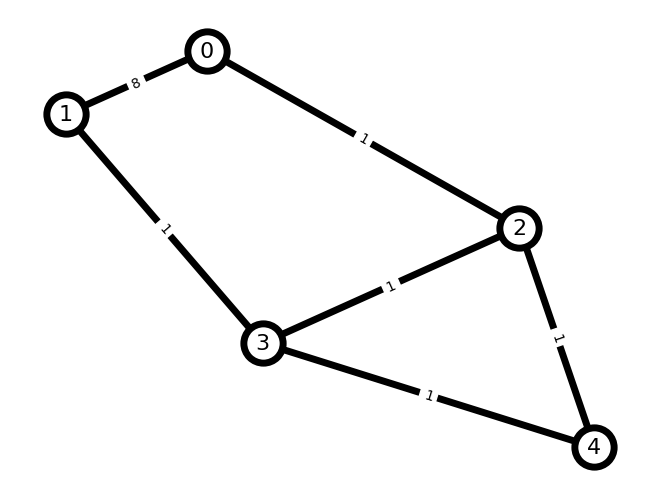

In [170]:
test_graph = nx.Graph()
test_graph.add_edges_from([(0,1, {"weight": 8}),(0,2, {"weight": 1}),(1,3, {"weight": 1}),(2,3, {"weight": 1}),(2,4, {"weight": 1}),(3,4, {"weight": 1})])
test_graph.order()

#est_graph = nx.OrderedGraph([(0,1),(0,2),(1,3),(2,3),(2,4),(3,4)])
pos = nx.spring_layout(test_graph,seed=1)

# Visualize graph
options = {
    "font_size": 16,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw(test_graph, pos, with_labels=True, **options)

labels = nx.get_edge_attributes(test_graph,'weight')
nx.draw_networkx_edge_labels(test_graph,pos,edge_labels=labels)

In [184]:
def gen_adj_matrix3(nx_G):
  adj_dict = defaultdict(int)

  for(u,v) in nx_G.edges:
    adj_dict[(u, v)] = nx_G[u][v]['weight']
    print(u,v, nx_G[u][v]['weight'])
  # adj_dict[(0,0)] = 14
  # adj_dict[(4,4)] = 14
  print("----")
  for u in nx_G.nodes:
    print(u)
    for i in nx_G.nodes:
      if not adj_dict[(u, i)]:
        adj_dict[(u, i)] = 0
    adj_dict[(0,0)] = 23
  print(adj_dict)
  return adj_dict

#gen_adj_matrix(test_graph)


def gen_adj_matrix2(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = nx_G[u][v]['weight'] - 13
        print(u,v, nx_G[u][v]['weight'])
    # adj_dict[(0,0)] = 14
    # adj_dict[(4,4)] = 14
    print("----")
    for u in nx_G.nodes:
        print(u)
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0
        adj_dict[(0,0)] = 1300
    print(adj_dict)
    return adj_dict

#gen_adj_matrix(test_graph)

def gen_adj_matrix(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = nx_G[u][v]['weight'] + (nx_G[u][v]['weight'] - 13)
        print(u,v, nx_G[u][v]['weight'])
    # adj_dict[(0,0)] = 14
    # adj_dict[(4,4)] = 14
    print("----")
    for u in nx_G.nodes:
        print(u)
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0
        adj_dict[(0,0)] = 13
    print(adj_dict)
    return adj_dict



# def gen_Q_matrix_min(nx_G):
#   adj_dict = defaultdict(int)

#   for(u,v) in nx_G.edges:
#     adj_dict[(u, v)] = nx_G[u][v]['weight']
#     print(u,v, nx_G[u][v]['weight'])
#   # adj_dict[(0,0)] = 14
#   # adj_dict[(4,4)] = 14
#   print("----")
#   for u in nx_G.nodes:
#     print(u)
#     for i in nx_G.nodes:
#       if not adj_dict[(u, i)]:
#         adj_dict[(u, i)] = 0
#   print(adj_dict)
#   return adj_dict

# gen_adj_matrix(test_graph)

def gen_adj_matrix5(graph):
    """
    Convert a weighted NetworkX graph into a QUBO matrix for the Min-Cut problem.

    Parameters:
    - graph: A weighted NetworkX graph

    Returns:
    - qubo: The QUBO matrix as a 2D NumPy array
    """
    n = len(graph.nodes)
    qubo = defaultdict(int)

    for i in graph.nodes:
        qubo[(i,i)] = sum(weight['weight'] for _, _, weight in graph.edges(i, data=True))

    for i, j, weight in graph.edges(data=True):
        qubo[(i,j)] = -2 * weight['weight']
    print(qubo)
    return qubo

gen_adj_matrix(test_graph)



# Constructs a random d-regular or p-probabilistic graph
#nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=test_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(test_graph, gen_adj_matrix(test_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

#est_graph = nx.OrderedGraph([(0,1),(0,2),(1,3),(2,3),(2,4),(3,4)])

0 1 8
0 2 1
1 3 1
2 3 1
2 4 1
3 4 1
----
0
1
2
3
4
defaultdict(<class 'int'>, {(0, 1): 3, (0, 2): -11, (1, 3): -11, (2, 3): -11, (2, 4): -11, (3, 4): -11, (0, 0): 13, (0, 3): 0, (0, 4): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 4): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0})
0 1 8
0 2 1
1 3 1
2 3 1
2 4 1
3 4 1
----
0
1
2
3
4
defaultdict(<class 'int'>, {(0, 1): 3, (0, 2): -11, (1, 3): -11, (2, 3): -11, (2, 4): -11, (3, 4): -11, (0, 0): 13, (0, 3): 0, (0, 4): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 4): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0})


### Problem-specific (MIS) utilities

In [185]:
# # helper function to generate Q matrix for Maximum Independent Set problem (MIS)
# def gen_q_dict_mis(nx_G, penalty=2):
#     """
#     Helper function to generate QUBO matrix for MIS as minimization problem.

#     Input:
#         nx_G: graph as networkx graph object (assumed to be unweigthed)
#     Output:
#         Q_dic: QUBO as defaultdict
#     """

#     # Initialize our Q matrix
#     Q_dic = defaultdict(int)

#     # Update Q matrix for every edge in the graph
#     # all off-diagonal terms get penalty
#     for (u, v) in nx_G.edges:
#         Q_dic[(u, v)] = penalty

#     # all diagonal terms get -1
#     for u in nx_G.nodes:
#         Q_dic[(u, u)] = -1

#     return Q_dic


# # Run classical greedy MAXCUT solver (provided by NetworkX)
# def run_maxcut_solver(nx_graph, seed = 0):
#     """
#     Helper function to run traditional greedy solver for MaxCUT.

#     Input:
#         nx_graph: networkx Graph object
#     Output:
#         ind_set_bitstring_nx: bitstring solution as list
#         ind_set_nx_size: size of independent set (int)
#         number_violations: number of violations of ind.set condition
#     """
#     random_state = np.random.RandomState(seed)
#     # compare with traditional solver
#     t_start = time()
#     cut_value, partition = one_exchange(nx_graph, seed=random_state)
#     t_solve = time() - t_start
#     set_size_1 = len(partition[0])
#     set_size_2 = len(partition[1])

#     # get bitstring list
#     # get bitstring list
#     nx_bitstring = [1 if (node in partition[0]) else 0 for node in sorted(list(nx_graph.nodes))]
#     edge_set = set(list(nx_graph.edges))

#     return nx_bitstring, set_size_1, set_size_2, t_solve, partition, cut_value


# # Calculate results given bitstring and graph definition, includes check for violations
# def postprocess_gnn_mis(best_bitstring, nx_graph):
#     """
#     helper function to postprocess MIS results

#     Input:
#         best_bitstring: bitstring as torch tensor
#     Output:
#         size_mis: Size of MIS (int)
#         ind_set: MIS (list of integers)
#         number_violations: number of violations of ind.set condition
#     """

#     # get bitstring as list
#     bitstring_list = list(best_bitstring)

#     # compute cost
#     size_mis = sum(bitstring_list)

#     # get independent set
#     ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
#     edge_set = set(list(nx_graph.edges))

#     print('Calculating violations...')
#     # check for violations
#     number_violations = 0
#     for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
#         number_violations += len(set(ind_set_chunk).intersection(edge_set))

#     return size_mis, ind_set, number_violations

#Specific to Max - Cut problem

In [186]:
# # helper function to generate Q matrix for Maximum Independent Set problem (MIS)
# def gen_q_dict_maxcut(nx_G):
#     """
#     Helper function to generate QUBO matrix for MIS as minimization problem.

#     Input:
#         nx_G: graph as networkx graph object (assumed to be unweigthed)
#     Output:
#         Q_dic: QUBO as defaultdict
#     """
#     Adj = nx.to_numpy_array(nx_G)
#     print(Adj)
#     S = Adj.sum(axis=0)
#     print(S)
#     Q_dic = defaultdict(int)
#     for (u, v) in nx_G.edges:
#         Q_dic[(u, v)] = 2
#     for u in nx_G.nodes:
#         Q_dic[(u, u)] = -S[u]

#     return Q_dic


# # Run classical MIS solver (provided by NetworkX)
# def run_min_solver(nx_graph):
#     """
#     helper function to run traditional solver for MIS.

#     Input:
#         nx_graph: networkx Graph object
#     Output:
#         ind_set_bitstring_nx: bitstring solution as list
#         ind_set_nx_size: size of independent set (int)
#         number_violations: number of violations of ind.set condition
#     """
#     # compare with traditional solver
#     t_start = time()
#     ind_set_nx = mis(nx_graph)
#     t_solve = time() - t_start
#     ind_set_nx_size = len(ind_set_nx)

#     # get bitstring list
#     nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
#     edge_set = set(list(nx_graph.edges))

#     # Updated to be able to handle larger scale
#     print('Calculating violations...')
#     # check for violations
#     number_violations = 0
#     for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
#         number_violations += len(set(ind_set_chunk).intersection(edge_set))

#     return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# # Calculate results given bitstring and graph definition, includes check for violations
# def postprocess_gnn_mis(best_bitstring, nx_graph):
#     """
#     helper function to postprocess MIS results

#     Input:
#         best_bitstring: bitstring as torch tensor
#     Output:
#         size_mis: Size of MIS (int)
#         ind_set: MIS (list of integers)
#         number_violations: number of violations of ind.set condition
#     """

#     # get bitstring as list
#     bitstring_list = list(best_bitstring)

#     # compute cost
#     size_mis = sum(bitstring_list)

#     # get independent set
#     ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
#     edge_set = set(list(nx_graph.edges))

#     print('Calculating violations...')
#     # check for violations
#     number_violations = 0
#     for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
#         number_violations += len(set(ind_set_chunk).intersection(edge_set))

#     return size_mis, ind_set, number_violations

# nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# # get DGL graph from networkx graph, load onto device
# graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
# graph_dgl = graph_dgl.to(TORCH_DEVICE)
# q_dict_maxcut = gen_q_dict_maxcut(nx_graph)

# Step 1 - Set hyperparameters

In [187]:
# Graph hypers
n = 5
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 5

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

# Step 2 - Generate random graph

In [188]:
# # Constructs a random d-regular or p-probabilistic graph
# nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# # get DGL graph from networkx graph, load onto device
# graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
# graph_dgl = graph_dgl.to(TORCH_DEVICE)

# # Construct Q matrix for graph
# q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

In [189]:
# Constructs a random d-regular or p-probabilistic graph
# nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# # get DGL graph from networkx graph, load onto device
# graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
# graph_dgl = graph_dgl.to(TORCH_DEVICE)

# # Construct Q matrix for graph
# q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_maxcut(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

In [190]:
# Visualize graph
# pos = nx.kamada_kawai_layout(nx_graph)
# nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

In [218]:
import torch
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from dgl.nn.pytorch import GraphConv
from itertools import chain, islice
from time import time


# GNN class to be instantiated with specified param values
class GCN_dev(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.

        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.

        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        #print('----')
        #print(h)
        h = torch.relu(h)
        #print(h)
        h = F.dropout(h, p=self.dropout_frac)
        #print(h)

        # output step
        h = self.conv2(g, h)
        #print(h)
        h = torch.sigmoid(h)
        #print(h)
        #print("----")
        # h[0] = th.tensor(0.25, requires_grad = True)
        # print("this is h",h)
        # h[0] = th.tensor(0.25, requires_grad = True)
        # print("this is h2",h)


        return h


# Generate random graph of specified size and type,
# with specified degree (d) or edge probability (p)
def generate_graph(n, d=None, p=None, graph_type='reg', random_seed=0):
    """
    Helper function to generate a NetworkX random graph of specified type,
    given specified parameters (e.g. d-regular, d=3). Must provide one of
    d or p, d with graph_type='reg', and p with graph_type in ['prob', 'erdos'].

    Input:
        n: Problem size
        d: [Optional] Degree of each node in graph
        p: [Optional] Probability of edge between two nodes
        graph_type: Specifies graph type to generate
        random_seed: Seed value for random generator
    Output:
        nx_graph: NetworkX OrderedGraph of specified type and parameters
    """
    if graph_type == 'reg':
        print(f'Generating d-regular graph with n={n}, d={d}, seed={random_seed}')
        nx_temp = nx.random_regular_graph(d=d, n=n, seed=random_seed)
    elif graph_type == 'prob':
        print(f'Generating p-probabilistic graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.fast_gnp_random_graph(n, p, seed=random_seed)
    elif graph_type == 'erdos':
        print(f'Generating erdos-renyi graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.erdos_renyi_graph(n, p, seed=random_seed)
    else:
        raise NotImplementedError(f'!! Graph type {graph_type} not handled !!')

    # Networkx does not enforce node order by default
    nx_temp = nx.relabel.convert_node_labels_to_integers(nx_temp)
    # Need to pull nx graph into OrderedGraph so training will work properly
    nx_graph = nx.Graph()
    nx_graph.order()
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
    nx_graph.add_edges_from(nx_temp.edges)
    return nx_graph


# helper function to convert Q dictionary to torch tensor
def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.

    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[x_coord][y_coord] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat


# Chunk long list
def gen_combinations(combs, chunk_size):
    yield from iter(lambda: list(islice(combs, chunk_size)), [])


# helper function for custom loss according to Q matrix
def loss_func(probs, Q_mat):
    """
    Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

    Input:
        probs: Probability of each node belonging to each class, as a vector
        Q_mat: QUBO as torch tensor
    """

    probs_ = torch.unsqueeze(probs, 1)
    # print(probs_)
    # print("___")
    # print(Q_mat)
    # print("probsitem")
    # print((probs.detach() >= 0.5) * 1)

    # minimize cost = x.T * Q * x
    cost = (probs_.T @ Q_mat @ probs_).squeeze()

    print(probs_)
    print(cost)

    print("end one loss")

    return cost

# helper function for custom loss according to Q matrix
def loss_func7(probs, Q_mat):
    """
    Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

    Input:
        probs: Probability of each node belonging to each class, as a vector
        Q_mat: QUBO as torch tensor
    """

    probs_ = torch.unsqueeze(probs, 1)
    # print(probs_)
    # print("___")
    # print(Q_mat)
    # print("probsitem")
    # print((probs.detach() >= 0.5) * 1)

    # minimize cost = x.T * Q * x
    cost = (probs_.T @ Q_mat).sum().squeeze()

    # print("cost item")
    # print((probs_.T @ Q_mat @ probs_))
    #print(probs_)
    #print(cost)
    #
    # print("end one loss")

    return cost

def loss_func6(probs, Q_mat):
    """
    Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

    Input:
        probs: Probability of each node belonging to each class, as a vector
        Q_mat: QUBO as torch tensor
    """

    probs_ = torch.unsqueeze(probs, 1)
    # print(probs_)
    # print("___")
    # print(Q_mat)
    # print("probsitem")
    # print((probs.detach() >= 0.5) * 1)

    # minimize cost = x.T * Q * x
    cost = (probs_.T @ Q_mat @ probs_).squeeze()

    terminal_constraint = 1.0 * torch.abs((probs_[0] >= 0.5) * 1 - (probs_[3] >= 0.5) * 1)
    terminal_constraint_loss = torch.sum(terminal_constraint)

    #print("cost item")
    #print((probs_.T @ Q_mat @ probs_))
    print(cost)

    #print("end one loss")

    return cost + terminal_constraint_loss

# helper function for custom loss according to Q matrix
def loss_func2(probs, Q_mat):
    """
    Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

    Input:
        probs: Probability of each node belonging to each class, as a vector
        Q_mat: QUBO as torch tensor
    """
    cost = 100
    probs_ = torch.unsqueeze(probs, 1)
    if (probs_[0] > 0.5 and probs_[4] > 0.5) or (probs_[0] < 0.5 and probs_[4] < 0.5):
      tensorItem =  th.tensor(100)
      tensorItem.requires_grad
      return th.stack([tensorItem])

    else:
      i = 0
      horizontal_sum = Q_mat.sum(1)
      vertical_sum = Q_mat.sum(0)
      summation = 0
      for probItem in probs_:
        if (probItem >= 0.5):
            summation += vertical_sum[i]

        i+=1
      tensorItem =  th.tensor(summation)
      tensorItem.requires_grad
      print("q_mat", Q_mat)
      print("sum hor q_mat", horizontal_sum)
      print("sum ver q_mat", vertical_sum)
      print("probs_", probs_)
      return th.stack([tensorItem])
      #return th.tensor([summation], requires_grad=True)

    return cost


# helper function for custom loss according to Q matrix
def loss_func3(probs, Q_mat):
    """
    Function to compute cost value for given probability of spin [prob(+1)] and predefined Q matrix.

    Input:
        probs: Probability of each node belonging to each class, as a vector
        Q_mat: QUBO as torch tensor
    """
    # cost = 100
    probs_ = torch.unsqueeze(probs, 1)
    if (probs_[0] > 0.5 and probs_[4] > 0.5) or (probs_[0] < 0.5 and probs_[4] < 0.5):
       tensorItem =  th.tensor(100)
       tensorItem.requires_grad
       cost = 2*((Q_mat @ probs_).sum()).squeeze()
       #print("this is after cost penalty" , cost)
       return th.tensor([99.], requires_grad = True)
    #   return th.stack([tensorItem])

    # else:
    cost = (Q_mat @ probs_).sum().squeeze()
    print("this is after cost reg" , cost)
    return cost
      #return th.tensor([summation], requires_grad=True)

def loss_func4(probs, Q_mat):
  adj_dict = defaultdict(int)
  probs_ = torch.unsqueeze(probs, 1)
  print("tense", probs_)

  if (probs_[0] >= 0.5 and probs_[4] >= 0.5) or (probs_[0] <= 0.5 and probs_[4] <= 0.5):
    print("comes to penalty," , 2 * (Q_mat.sum().squeeze()))
    return th.tensor([2 * (Q_mat.sum().squeeze())], requires_grad = True)
  i = 0
  for i in Q_mat.size():
    j = 0
    for j in Q_mat.size():
      if (probs_[i] > 0.5 and probs_[j] > 0.5) or (probs_[i] < 0.5 and probs_[j] < 0.5):
        adj_dict[i][j] = 0
      else:
        adj_dict[i][j] = Q_mat[i][j]

      j+=1
    i+=1

    print("real value, " , adj_dict)

  return adj_dict.sum().squeeze()

def loss_func5(probs, Q_mat):
  adj_dict = defaultdict(int)
  probs_ = torch.unsqueeze(probs, 1)
  print("tense", probs_)

  a = torch.rand(2, 2, dtype=float)*100

  print("logical and", th.logical_and(probs_[0] >= 0.5, probs_[4] >= 0.5))
  print("logical and", th.logical_and(probs_[0] >= 0.5, probs_[4] >= 0.5)[0])
  print("testing and", probs_>0.5)
  print("testing and complete", probs_[0] >= 0.5 and probs_[4] >= 0.5)
  print("output 1", 2 * (Q_mat.sum().squeeze()))
  print("output 2", 2 * (Q_mat.sum()))

  #return th.where( (th.logical_and(probs_[0] >= 0.5, probs_[4] >= 0.5))[0], 1.0,0.1)
  return th.where( (th.logical_and(probs_[0] >= 0.5, probs_[4] >= 0.5) or th.logical_and(probs_[0] <= 0.5 , probs_[4] <= 0.5))[0],
                   probs_.sum()*2*Q_mat.clone().detach().sum().requires_grad_(True),
             (th.tensor((Q_mat.sum().squeeze()), requires_grad = True)))

  # if (probs_[0] >= 0.5 and probs_[4] >= 0.5) or (probs_[0] <= 0.5 and probs_[4] <= 0.5):
  #   print("comes to penalty," , 2 * (Q_mat.sum().squeeze()))
  #   return th.tensor([2 * (Q_mat.sum().squeeze())], requires_grad = True)
  # i = 0
  # for i in Q_mat.size():
  #   j = 0
  #   for j in Q_mat.size():
  #     if (probs_[i] > 0.5 and probs_[j] > 0.5) or (probs_[i] < 0.5 and probs_[j] < 0.5):
  #       adj_dict[i][j] = 0
  #     else:
  #       adj_dict[i][j] = Q_mat[i][j]

  #     j+=1
  #   i+=1

    # print("real value, " , adj_dict)

  return adj_dict.sum().squeeze()

#def loss_Helper()
    #return cost
# Construct graph to learn on
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCN_dev(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

class weightConstraint(object):
    def __init__(self):
        pass

    def __call__(self,module):
        if hasattr(module,'weight'):
            print("Entered")
            w=module.weight.data
            w=w.clamp(0.7,0.9)
            module.weight.data=w

# Parent function to run GNN training given input config
def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    #print("input", inputs.data.fill_(1))

    prev_loss = 100.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch)

    t_gnn_start = time()

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        torch.autograd.set_detect_anomaly(True)
        probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model
        #probs = torch.unsqueeze(probs, 1)

        # print("this is probs" , probs)
        # print("this is probs[0]" , probs[0])
        #probs[0] = th.tensor(0.25, requires_grad = True)
        #probs[-1] = th.tensor(0.75, requires_grad = True)

        #probs.squeeze()
        # print("this is after probs[0]" , probs[0])
        #print("this is after probs" , probs)
        # probs.retain_grad()
        #print("this is after retains probs" , probs)
        #print("printing probs", probs[0])
        # build cost value with QUBO cost function
        loss = loss_func7(probs, q_torch)
        #loss.requires_grad
        #print("comes here", loss)
        loss_ = loss.detach().item()
        #print("comes here2", loss_)
        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        if loss < best_loss:
            best_loss = loss
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print("probs:", (probs.detach() >= prob_threshold) * 1)
            print(f'Epoch: {epoch}, Loss: {loss_}')
            print(net.conv1.weight.data)

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
            count += 1
        else:
            count = 0

        if count >= patience:
            print(f'Stopping early on epoch {epoch} (patience: {patience})')
            #break
        torch.autograd.set_detect_anomaly(True)
        # update loss tracking
        prev_loss = loss_
        #print("backwardf loss", loss)
        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        #print("is leaf", loss.is_leaf)
        #print(probs.)
        loss.backward()        # calculate gradient through compute graph
        #print(list(net.parameters())[0].grad)
        optimizer.step()       # take step, update weights
        #net.conv2.apply(weightConstraint())


    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring


In [219]:
# Establish pytorch GNN + optimizer
#opt_params = {'lr': learning_rate}
opt_params = {'lr': 0.001}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    #'number_epochs': number_epochs,
    'number_epochs':1000000000000,
    #'tolerance': tol,
    'tolerance': 0.00001,
    #'patience': patience
    'patience': 100000000
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

# Step 4 - Run GNN training

In [220]:
print('Running GNN...')
gnn_start = time()
#net.conv2.apply(weightConstraint())
_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, 10000,
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor(0.)
end one loss
probs: tensor([1, 1, 1, 1, 1])
Epoch: 0, Loss: -19.5
tensor([[ 1.1636],
        [-0.3425]])
probs: tensor([1, 1, 1, 1, 1])
Epoch: 1000, Loss: -28.17818260192871
tensor([[ 1.1636],
        [-0.3425]])
probs: tensor([1, 1, 1, 1, 1])
Epoch: 2000, Loss: -33.2197265625
tensor([[ 1.1636],
        [-0.3425]])
probs: tensor([1, 1, 1, 1, 1])
Epoch: 3000, Loss: -35.73889923095703
tensor([[ 1.1636],
        [-0.3425]])
probs: tensor([1, 1, 1, 1, 1])
Epoch: 4000, Loss: -37.058326721191406
tensor([[ 1.1636],
        [-0.3425]])
probs: tensor([1, 1, 1, 1, 1])
Epoch: 5000, Loss: -37.8000373840332
tensor([[ 1.1636],
        [-0.3425]])
probs: tensor([1, 1, 1, 1, 1])
Epoch: 6000, Loss: -38.24041748046875
tensor([[ 1.1636],
        [-0.3425]])
probs: tensor([1, 1, 1, 1, 1])
Epoch: 7000, Loss: -38.511802673339844
tensor([[ 1.1636],
        [-0.3425]])
probs: tensor([1, 1, 1, 1, 1])
Epoch: 8000, L

In [223]:
final_bitstring

tensor([0, 0, 1, 1, 1])

# new implementation of the NN

In [16]:
import torch
import torch.nn.functional as F

def maximum_flow_loss(predicted_flows, actual_flows, capacities, source_node, sink_node, penalty_weight=1.0):
    """
    Custom loss function for the maximum flow problem with terminal constraints.

    Args:
        predicted_flows (Tensor): Predicted flow values for each edge (batch_size x num_edges).
        actual_flows (Tensor): Actual flow values for each edge (batch_size x num_edges).
        capacities (Tensor): Capacities of each edge (batch_size x num_edges).
        source_node (int): Index of the source node.
        sink_node (int): Index of the sink node.
        penalty_weight (float): Weight for the penalty term to enforce terminal constraints.

    Returns:
        Tensor: Combined loss value.
    """
    # Regression Loss: Mean Squared Error (MSE) loss between predicted and actual flows
    regression_loss = F.mse_loss(predicted_flows, actual_flows)

    # Constraint Enforcement: Ensure predicted flows do not exceed capacities
    exceeding_capacities = torch.clamp(predicted_flows - capacities, min=0)
    constraint_loss = torch.sum(exceeding_capacities)

    # Terminal Constraint: Penalize if source and sink are classified in the same set
    terminal_constraint = penalty_weight * torch.abs(predicted_flows[:, source_node] - predicted_flows[:, sink_node])
    terminal_constraint_loss = torch.sum(terminal_constraint)

    # Combined Loss: Combination of regression, constraint, and terminal constraint loss
    loss = regression_loss + constraint_loss + terminal_constraint_loss

    return loss


[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]
[[1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [0. 1. 1. 1.]
 [1. 0. 1. 1.]]
tensor([[0.3333, 0.3333, 0.0000, 0.3333],
        [0.3333, 0.3333, 0.3333, 0.0000],
        [0.0000, 0.3333, 0.3333, 0.3333],
        [0.3333, 0.0000, 0.3333, 0.3333]])
tensor([[ 0.2177,  0.1212, -0.0322,  0.0540],
        [ 0.2089,  0.1146, -0.0032,  0.0556],
        [ 0.2300,  0.1085, -0.0115,  0.0405],
        [ 0.2088,  0.1326, -0.0196,  0.0799]], grad_fn=<AddmmBackward0>)


NameError: name 'actual_flows' is not defined

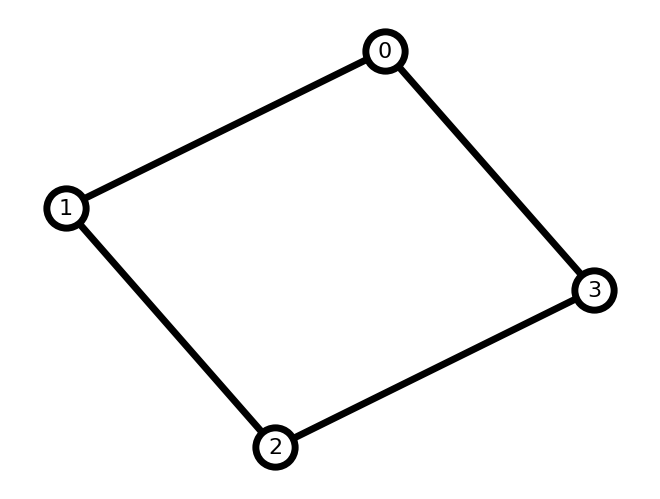

In [17]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import networkx as nx
# import numpy as np
import torch.optim as optim

# Define the Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = nn.Linear(num_features, hidden_size)
        self.conv2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, adjacency_matrix):
        x = F.relu(self.conv1(torch.matmul(adjacency_matrix, x)))
        x = self.conv2(torch.matmul(adjacency_matrix, x))
        return x

# Preprocessing module for graph data
class GraphPreprocessor:
    def __init__(self, graph, source_node, sink_node):
        self.graph = graph
        self.source_node = source_node
        self.sink_node = sink_node

    def _normalize_adjacency(self, adjacency):
        degree = np.array(adjacency.sum(1))
        d_inv_sqrt = np.power(degree, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = np.diag(d_inv_sqrt)
        normalized_adjacency = np.dot(np.dot(d_mat_inv_sqrt, adjacency), d_mat_inv_sqrt)
        return normalized_adjacency

    def preprocess_graph(self):
        # Convert the NetworkX graph to an adjacency matrix
        adjacency_matrix = nx.to_numpy_array(self.graph)

        print(adjacency_matrix)

        # Add self-loops (optional, based on the specific problem)
        np.fill_diagonal(adjacency_matrix, 1.0)

        #print(adjacency_matrix)

        # Normalize the adjacency matrix (optional, depending on the GCN variant)
        normalized_adjacency = self._normalize_adjacency(adjacency_matrix)

        print(adjacency_matrix)

        # Convert the adjacency matrix to a PyTorch tensor
        normalized_adjacency = torch.FloatTensor(normalized_adjacency)

        # Identify source and sink nodes
        source_node = torch.tensor([self.source_node], dtype=torch.long)
        sink_node = torch.tensor([self.sink_node], dtype=torch.long)

        return normalized_adjacency, source_node, sink_node

# Example usage:
# Create a NetworkX graph
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

pos = nx.spring_layout(graph,seed=1)

# Visualize graph
options = {
    "font_size": 16,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw(graph, pos, with_labels=True, **options)

labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

# Specify the source and sink nodes
source_node = 0
sink_node = 3

# Initialize the graph preprocessor
preprocessor = GraphPreprocessor(graph, source_node, sink_node)

# Preprocess the graph
adjacency_matrix, source_node, sink_node = preprocessor.preprocess_graph()

print(adjacency_matrix)

# Initialize GCN model
num_features = graph.number_of_nodes()  # Number of nodes in the graph
hidden_size = 64
num_classes = graph.number_of_edges()  # Number of edges in the graph
model = GCN(num_features, hidden_size, num_classes)

# Forward pass through GCN
output = model(torch.eye(num_features), adjacency_matrix)  # Identity matrix as node features for simplicity
print(output)


# Initialize GCN model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predicted_flows = model(torch.eye(num_features), adjacency_matrix)  # Forward pass, features and adjacency_matrix are your data
    loss = maximum_flow_loss(predicted_flows, actual_flows, capacities, source_node, sink_node, penalty_weight=1.0)
    loss.backward()
    optimizer.step()

    # Print the loss for every few epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, you can use the model for inference
model.eval()
predicted_flows = model(torch.eye(num_features), adjacency_matrix)

In [ ]:
def conservation_of_flow_loss(predicted_flows, adjacency_matrix, source_node, sink_node):
    incoming_flows = torch.sum(adjacency_matrix * predicted_flows, dim=1)
    outgoing_flows = torch.sum(adjacency_matrix * predicted_flows, dim=0)
    source_loss = torch.abs(torch.sum(incoming_flows) - torch.sum(outgoing_flows[source_node]))
    sink_loss = torch.abs(torch.sum(outgoing_flows) - torch.sum(incoming_flows[sink_node]))
    total_loss = source_loss + sink_loss
    return total_loss
def capacity_constraint_loss(predicted_flows, capacities):
    exceeded_capacities = torch.max(predicted_flows - capacities, torch.zeros_like(predicted_flows))
    total_loss = torch.sum(exceeded_capacities)
    return total_loss
def total_loss(predicted_flows, adjacency_matrix, capacities, source_node, sink_node):
    conservation_loss = conservation_of_flow_loss(predicted_flows, adjacency_matrix, source_node, sink_node)
    capacity_loss = capacity_constraint_loss(predicted_flows, capacities)
    total_loss = conservation_loss + capacity_loss
    return total_loss


In [ ]:
#test

# Create a NetworkX graph
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])


# Specify the source and sink nodes
source_node = 0
sink_node = 3

# Initialize the graph preprocessor
preprocessor = GraphPreprocessor(graph, source_node, sink_node)

# Preprocess the graph
adjacency_matrix, source_node, sink_node = preprocessor.preprocess_graph()

# Initialize GCN model
num_features = graph.number_of_nodes()  # Number of nodes in the graph
hidden_size = 64
num_classes = graph.number_of_edges()  # Number of edges in the graph
model = GCN(num_features, hidden_size, num_classes)

# Define the optimizer and the custom loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predicted_flows = model(torch.eye(num_features), adjacency_matrix)  # Identity matrix as node features for simplicity

    # Define actual_flows and capacities based on your dataset
    actual_flows = torch.tensor([0.5, 0.8, 0.7, 0.3], dtype=torch.float32)  # Example values
    capacities = torch.tensor([1.0, 8.0, 8.0, 1.0], dtype=torch.float32)  # Example values

    # Compute the loss using the custom loss function
    #loss = maximum_flow_loss(predicted_flows, actual_flows, capacities, source_node, sink_node, penalty_weight=1.0)
    loss =total_loss(predicted_flows, adjacency_matrix, capacities, source_node, sink_node)
    loss.backward()
    optimizer.step()

    # Print the loss for every few epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    output_flow = predicted_flows.detach()

print(output_flow)
print((output_flow.detach() >= 0) * 1)

In [ ]:


# Define the Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, output_dim)

    def forward(self, g, features):
        x = self.conv1(g, features)
        x = torch.relu(x)
        x = self.conv2(g, x)
        return x

# Loss function: Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()

# Training function
def train_model(graph, model, num_epochs=100, learning_rate=0.01):
    # Generate node features (one-hot encoding for simplicity)
    num_nodes = graph.number_of_nodes()
    node_features = torch.eye(num_nodes)

    # Generate adjacency matrix
    #adj_matrix = nx.to_numpy_array(graph, nodelist=[0,1,2,3,4])
    adj_matrix = gen_adj_matrix(graph)

    #g = dgl.graph(adj_matrix)
    g = qubo_dict_to_torch(graph, adj_matrix, torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    # Create target labels (1 for nodes in one subset, 0 for nodes in the other subset)
    labels = np.zeros((num_nodes,))
    # Set source and sink nodes to different subsets
    labels[0] = 1  # Source node
    labels[num_nodes - 1] = 1  # Sink node
    labels = torch.tensor(labels, dtype=torch.float32)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(g, node_features)

        # Compute loss
        #loss = criterion(outputs, labels)
        loss = criterion(outputs[1:-1], labels[1:-1])

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # After training, the model parameters contain the learned information for minimum cut

# Example usage:
# Create a graph using nx.Graph()
graph = nx.Graph()
#graph.add_edges_from([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4),])

graph.add_edges_from([(0,1, {"weight": 8}),(0,2, {"weight": 1}),(1,3, {"weight": 1}),(2,3, {"weight": 1}),(2,4, {"weight": 1}),(3,4, {"weight": 1})])

pos = nx.spring_layout(graph,seed=1)

# Visualize graph
options = {
    "font_size": 16,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw(graph, pos, with_labels=True, **options)

labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)


# Define model, criterion, and train the model
input_dim = graph.number_of_nodes()
hidden_dim = 64
output_dim = 1
model = GCN(input_dim, hidden_dim, output_dim)
train_model(graph, model)


# Step 5 - Post-process GNN results

In [ ]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# # Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

# print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
# print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

In [ ]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring.detach().numpy()])

# Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')


hamiltonian_maxcut = -loss_func(best_bitstring,q_torch.type(torch.LongTensor))
print( hamiltonian_maxcut.detach().numpy())

In [ ]:
# Visualize result
# Note no light-blue nodes are connected by an edge
print(best_bitstring)
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in test_graph.nodes]
nx.draw(test_graph, pos, with_labels=True, node_color=color_map)

# Step 6 - (optional) Compare to classical solver

In [ ]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve,_,cutValue = run_maxcut_solver(nx_graph)
end = time()
runtime_sol = end - start
# print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
# print(f'MIS solver took {round(runtime_sol, 3)}s')
print("Max cut value:" + str(cutValue))